<a href="https://colab.research.google.com/github/MatheusHenriqueDaSilva/data_science/blob/main/diabetes_LGMB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prevenção do início da diabetes com base em medidas de diagnóstico

Etapas:
1.   Data prep
2.   treinamento (Cross Validation na base de treino) e otimização de hiperparâmetros
3.   Avaliação do Light GBM




In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

In [6]:
# Data understanding
DATA = pd.read_csv('/content/diabetes.csv')
DATA.head()

(768, 9)

In [4]:
DATA.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
def generate_metadata(dataframe):

    metadata2 = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata2=metadata2.sort_values(by='tipo')
    metadata2 = metadata2.reset_index(drop=True)

    return metadata2

metadados = generate_metadata(DATA)
metadados

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,Pregnancies,int64,0,0.0,17
1,Glucose,int64,0,0.0,136
2,BloodPressure,int64,0,0.0,47
3,SkinThickness,int64,0,0.0,51
4,Insulin,int64,0,0.0,186
5,Age,int64,0,0.0,52
6,Outcome,int64,0,0.0,2
7,BMI,float64,0,0.0,248
8,DiabetesPedigreeFunction,float64,0,0.0,517


In [7]:
# Realizando HOLD-OUT da base, buscando conseguir avaliar o modelo posteriormente.
lista_spec = ['Outcome']
target = DATA['Outcome']
data_var = DATA.drop(lista_spec,axis=1)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(data_var,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((537, 8), (231, 8), (537,), (231,))

In [10]:
# FEATURE SELECTION
from sklearn.ensemble import RandomForestClassifier

X = X_train
y = Y_train

clf = RandomForestClassifier() # troque aqui qual classificador quer utilizar: GradientBoostingClassifier, DecisionTreeClassifier
clf.fit(X, y)

# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)
features

,Feature,Importance
1,Glucose,0.260388
5,BMI,0.178400
7,Age,0.150478
6,DiabetesPedigreeFunction,0.116272
2,BloodPressure,0.079683
0,Pregnancies,0.077733
3,SkinThickness,0.068737
4,Insulin,0.068308


In [11]:
# Analisando as variáveis, concluí que todas possuem relevancia suficiente para utiliza-las no modelo
# observando evento e não evento

Y_train.describe()


count    537.000000
mean       0.350093
std        0.477444
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Outcome, dtype: float64

In [72]:
# criando o melhor preditor de light GBM
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

x = X_train
y = Y_train

# Definindo o modelo
model = lgb.LGBMClassifier(random_state=42)

# Definindo os parâmetros para o grid search
param_grid = {
    'n_estimators': [50],
    'max_depth' : [2, 3, 4],
    'num_leaves': [5, 7, 9 , 11],
    'reg_alpha': [0.1 , 0, 0.5],
    'min_data_in_leaf': [2, 3, 4],
    'lambda_l1': [1 , 0.1, 0.01],
    'lambda_l2': [1, 0.1, 0.2]
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=2, # diminui o numero de folds por conta do baixo número de observações
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'roc_auc' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(x, y)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(x)

best_model_LGBM = grid.best_estimator_

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Info] Number of positive: 188, number of negative: 349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 606
[LightGBM] [Info] Number

In [73]:
with open('/content/best_model_lightgbm.pkl', 'wb') as file:
  pickle.dump(best_model_LGBM, file)
best_model_LGBM

LGBMClassifier(lambda_l1=0.01, lambda_l2=1, max_depth=4, min_data_in_leaf=2,
               n_estimators=50, num_leaves=5, random_state=42, reg_alpha=0.1)

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report


predict = best_model_LGBM.predict(X_test)

print(confusion_matrix(Y_test, predict))
print(accuracy_score(Y_test, predict))
print(classification_report(Y_test, predict))

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.01
[[121  30]
 [ 28  52]]
0.7489177489177489
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       151
           1       0.63      0.65      0.64        80

    accuracy                           0.75       231
   macro avg       0.72      0.73      0.72       231
weighted avg       0.75      0.75      0.75       231



In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df


# Uso da função
metrics_df = calculate_metrics('lightGBM',best_model_LGBM, x, y, X_test, Y_test)
metrics_df

[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] min_

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,lightGBM,Treino,0.860335,0.812155,0.781915,0.936871,0.873743,0.721682
1,lightGBM,Teste,0.748918,0.634146,0.650000,0.811258,0.622517,0.487417


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning

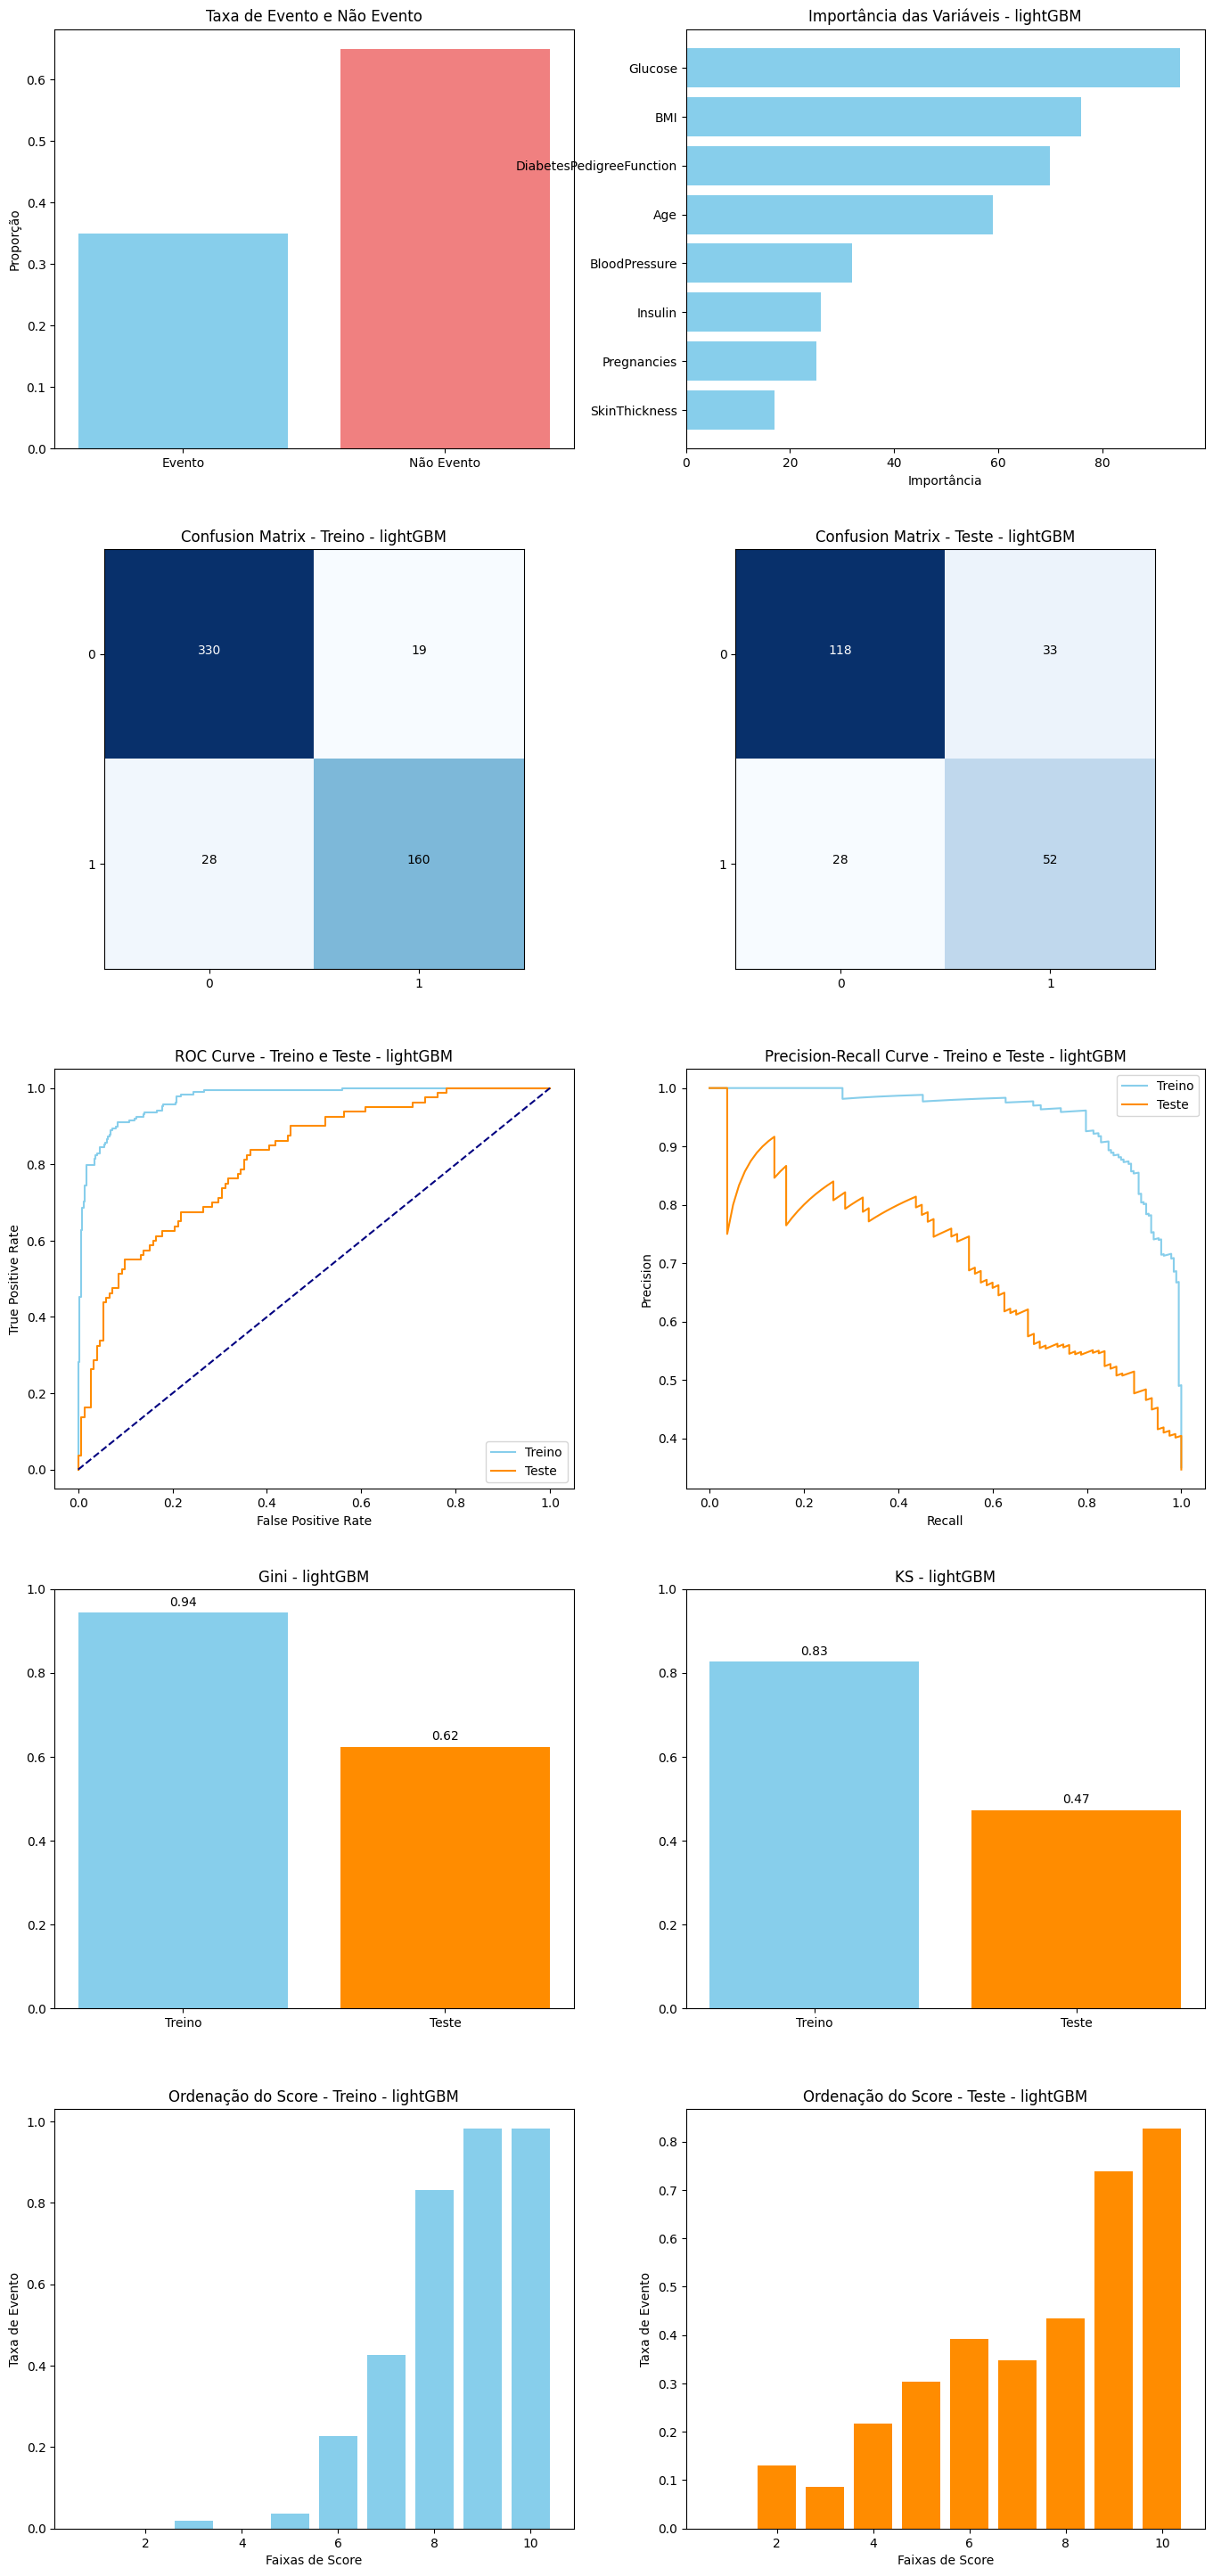

In [58]:
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score
def calcular_ks_statistic(y_true, y_score):
    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values(by='score', ascending=False)
    total_events = df.target.sum()
    total_non_events = len(df) - total_events
    df['cum_events'] = df.target.cumsum()
    df['cum_non_events'] = (df.target == 0).cumsum()
    df['cum_events_percent'] = df.cum_events / total_events
    df['cum_non_events_percent'] = df.cum_non_events / total_non_events
    ks_statistic = np.abs(df.cum_events_percent - df.cum_non_events_percent).max()
    return ks_statistic

def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Ajustado para incluir novos gráficos
    plt.tight_layout(pad=6.0)

    # Cor azul claro
    cor = 'skyblue'

    # Taxa de Evento e Não Evento
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos
    importancias = None
    if hasattr(modelo, 'coef_'):
        importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_

    if importancias is not None:
        importancias_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
        importancias_df = importancias_df.sort_values(by='importance', ascending=True)

        axs[0, 1].barh(importancias_df['feature'], importancias_df['importance'], color=cor)
        axs[0, 1].set_title('Importância das Variáveis - ' + nm_modelo)
        axs[0, 1].set_xlabel('Importância')

    else:
        axs[0, 1].axis('off')  # Desativa o subplot se não houver importâncias para mostrar

    # Confusion Matrix - Treino
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')


    # Decile Analysis - Teste
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)  # Adiciona um pequeno ruído
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)  # Adiciona um pequeno ruído
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos
    plt.show()
avaliar_modelo(x, y, X_test, Y_test, best_model_LGBM,nm_modelo='lightGBM')

### Conclusão
- devido ao baixo número de observações, o mais indicado seria utilizar algum outro modelo, por estar ocorrendo overfiting.
- A alternativa mais viável aqui pela minha análise seria testar o random forest, um KNN ou um SVM, a primeira opção eu tentaria para tentar combater o overfiting, e o KNN e o SVM por conta da volumetria mais baixa.
